In [581]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from numpy.polynomial import Polynomial

In [582]:
def p_diode(x):
  if x <= 500:
    y = 6.6763288698E-12*x**5 - 1.3543608284E-08*x**4 + 1.0888317706E-05*x**3 - 4.3335323943E-03*x**2 + 8.5399725862E-01*x - 6.6558844853E+01
  elif 500 <= x < 950:
    y = 5.5585093168E-04*x - 2.0552365026E-02
  elif 950 <= x <= 1100:
    y = 3.1698368227E-09*x**4 - 1.2731281453E-05*x**3 + 1.9132245041E-02*x**2 - 1.2752168975E+01*x + 3.1818412914E+03
  return y

In [583]:
import pandas as pd
import numpy as np
from datetime import datetime
format_data = "%m%d%y_%H%M%S"
df = pd.read_table(r"Данные\Калибровка_041224_145832_.txt",  decimal='.')
df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern

df = df.loc[df.Wavelength >= 300][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
df

df["norm_current_uA"] = (df["Current"] - df["Current"].min())/(df["Current"].max() - df["Current"].min())
df["Shutter"] = df["Shutter"].shift(-23)

px.line(df, "Time", ["norm_current_uA","Shutter"])

In [584]:
calibration = pd.DataFrame([])
df = df.dropna()
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Current"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-50:]["Current"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(calibration)])
    calibration = pd.concat([calibration, new_row])
px.line(calibration, "Wavelength", ["Photocurrent"])

In [585]:
df = pd.read_table(r"Данные\DCV_042224_144304_.txt",  decimal=',')
format_data = "%m%d%y_%H%M%S"
df["Time"] = df.Timestamp.apply( lambda x: datetime.strptime(x, format_data))
df["Time"] = df["Time"] - df["Time"][0]
df["Time"] = df["Time"].dt.total_seconds()
for i in range(int(df.Time[df.index[-1]])):
    pattern = np.linspace(0,1,len(df[df.Time == i]))
    df.loc[df.Time == i, "Time"] += pattern
df = df.loc[df.Wavelength >= 315][["Time", "Current", "Wavelength", "Shutter"]].copy(deep=True)
df

,Time,Current,Wavelength,Shutter
618,88.000000,5.477515e-07,320,1.0
619,88.090909,5.284357e-07,320,1.0
620,88.181818,5.205310e-07,320,1.0
621,88.272727,5.169567e-07,320,1.0
622,88.363636,5.181048e-07,320,1.0
...,...,...,...,...
5937,566.000000,-4.273066e-08,440,0.0
5938,566.000000,-4.271421e-08,440,0.0
5939,566.000000,-4.276080e-08,440,0.0
5940,566.000000,-4.283544e-08,440,0.0


In [586]:
grouped = df.groupby('Wavelength')
result = grouped["Current"].apply(lambda x: x.tail(50).mean())
dark = pd.DataFrame({'Wavelength': result.index, 'mean_current': result.values})
dark

,Wavelength,mean_current
0,320,1.673505e-07
1,330,9.804913e-08
2,340,5.740143e-08
3,350,3.480923e-08
4,360,1.631928e-08
5,370,7.322042e-09
6,380,-4.145223e-09
7,390,-1.349774e-08
8,400,-1.975712e-08
9,410,-2.599516e-08


In [587]:
darck_current = df.loc[df.Shutter == 0]
darck_current["Change_wavelength"] = df['Wavelength'].diff().ne(0).astype(int)
daseline = darck_current.loc[darck_current.Change_wavelength > 0].copy(deep=True)
#daseline = pd.concat([pd.DataFrame({"Time": df["Time"][df.index.min()], "Current": df["Current"][df.index.min()]}, index=[0]), daseline[["Time","Current"]]], axis=0)
daseline = daseline[["Time","Current"]]
daseline = daseline.reset_index(drop=True)
daseline = pd.concat([daseline, dark],axis=1)
daseline["mean_current"] =  daseline["mean_current"].shift(0)

C:\Users\butma\AppData\Local\Temp\ipykernel_21864\1197917852.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



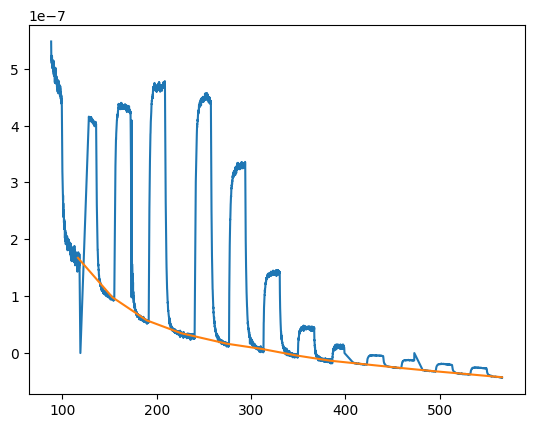

In [588]:
plt.plot(df.Time, df.Current)
plt.plot(daseline.Time, daseline.mean_current)

In [589]:
df

,Time,Current,Wavelength,Shutter
618,88.000000,5.477515e-07,320,1.0
619,88.090909,5.284357e-07,320,1.0
620,88.181818,5.205310e-07,320,1.0
621,88.272727,5.169567e-07,320,1.0
622,88.363636,5.181048e-07,320,1.0
...,...,...,...,...
5937,566.000000,-4.273066e-08,440,0.0
5938,566.000000,-4.271421e-08,440,0.0
5939,566.000000,-4.276080e-08,440,0.0
5940,566.000000,-4.283544e-08,440,0.0


In [590]:
daseline.loc[0, "mean_current"] = df.Current[df.index.min()]
daseline

,Time,Current,Wavelength,mean_current
0,116.416667,1.553861e-07,320,5.477515e-07
1,152.916667,9.429760e-08,330,9.804913e-08
2,189.454545,5.644491e-08,340,5.740143e-08
3,225.916667,3.275768e-08,350,3.480923e-08
4,274.583333,1.484234e-08,360,1.631928e-08
5,311.083333,5.074509e-09,370,7.322042e-09
6,347.583333,-6.230104e-09,380,-4.145223e-09
7,384.083333,-1.508040e-08,390,-1.349774e-08
8,420.666667,-1.984744e-08,400,-1.975712e-08
9,457.083333,-2.636163e-08,410,-2.599516e-08


In [591]:
daseline = daseline.dropna()
base = Polynomial.fit(daseline.Time, daseline.mean_current, 4)
df["baseline"] = base(df.Time)
df["Photocurrent"] = df.Current - df.baseline
df

,Time,Current,Wavelength,Shutter,baseline,Photocurrent
618,88.000000,5.477515e-07,320,1.0,8.511723e-07,-3.034208e-07
619,88.090909,5.284357e-07,320,1.0,8.498205e-07,-3.213848e-07
620,88.181818,5.205310e-07,320,1.0,8.484702e-07,-3.279392e-07
621,88.272727,5.169567e-07,320,1.0,8.471214e-07,-3.301647e-07
622,88.363636,5.181048e-07,320,1.0,8.457740e-07,-3.276692e-07
...,...,...,...,...,...,...
5937,566.000000,-4.273066e-08,440,0.0,-1.989310e-08,-2.283756e-08
5938,566.000000,-4.271421e-08,440,0.0,-1.989310e-08,-2.282111e-08
5939,566.000000,-4.276080e-08,440,0.0,-1.989310e-08,-2.286770e-08
5940,566.000000,-4.283544e-08,440,0.0,-1.989310e-08,-2.294234e-08


<Axes: xlabel='Time'>

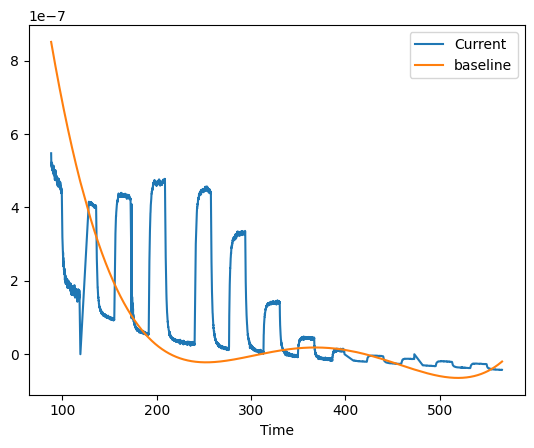

In [592]:
df[["Time", "Current", "baseline"]].plot(x="Time")

In [593]:
px.line(df, "Time", "Photocurrent")

In [594]:
IPCE_df = pd.DataFrame([])
df = df.dropna() 
for wavelength in df["Wavelength"].unique():
    mono_df = df.loc[df["Wavelength"] == wavelength]
    light_df = mono_df.loc[df.Shutter == 1, "Photocurrent"]
    light_df = light_df[10:-2]
    photocurrent = light_df.median() - mono_df[-100:-50]["Photocurrent"].median()
    new_row = pd.DataFrame({"Wavelength": wavelength, "Photocurrent": photocurrent}, index=[len(IPCE_df)])
    IPCE_df = pd.concat([IPCE_df, new_row])
px.line(IPCE_df, "Wavelength", ["Photocurrent"])
IPCE_df["K_diode"] = IPCE_df["Wavelength"].apply(p_diode)
IPCE_df["Мощность излучения, мкВт"] = calibration["Photocurrent"]/IPCE_df["K_diode"]
IPCE_df["IPCE"] = (IPCE_df["Photocurrent"]/7)*1240/IPCE_df["Wavelength"]/IPCE_df["Мощность излучения, мкВт"]*100
#IPCE_df
px.line(IPCE_df, "Wavelength", ["IPCE"])